In [2]:
import numpy as np
import time
from scipy.ndimage import label
import matplotlib.pyplot as plt


In [3]:
# Define the non-convex function
def f(x):
    """Objective function: f(x, y) = x^4 + y^4 - 4x^2 - 4y^2"""
    return x[0]**4 + x[1]**4 - 4*x[0]**2 - 4*x[1]**2

# Define the gradient of the function
def grad_f(x):
    """Gradient of f."""
    df_dx = 4*x[0]**3 - 8*x[0]
    df_dy = 4*x[1]**3 - 8*x[1]
    return np.array([df_dx, df_dy])

# Define the Hessian of the function
def hessian_f(x):
    """Hessian matrix of f."""
    d2f_dx2 = 12*x[0]**2 - 8
    d2f_dy2 = 12*x[1]**2 - 8
    return np.array([[d2f_dx2, 0],
                     [0, d2f_dy2]])

# Identify convex regions based on Hessian eigenvalues
def identify_convex_regions(grid_points):
    """Identify convex and non-convex regions."""
    convex_regions = []
    nonconvex_regions = []
    for point in grid_points:
        H = hessian_f(point)
        eigenvalues = np.linalg.eigvalsh(H)
        if np.all(eigenvalues > 0):
            convex_regions.append(point)
        else:
            nonconvex_regions.append(point)
    return convex_regions, nonconvex_regions

def is_positive_definite(H):
    """
    Check if a given Hessian matrix H is positive definite.

    Parameters:
        H (np.ndarray): Hessian matrix.

    Returns:
        bool: True if H is positive definite, False otherwise.
    """
    # Compute eigenvalues using a symmetric eigenvalue solver
    eigenvalues = np.linalg.eigvalsh(H)
    return np.all(eigenvalues > 0)

def compute_hessian(x, y):
    """
    Compute the Hessian matrix of the function f(x, y) = x^4 + y^4 -4x^2 -4y^2.

    Parameters:
        x (float): x-coordinate.
        y (float): y-coordinate.

    Returns:
        np.ndarray: Hessian matrix at (x, y).
    """
    d2f_dx2 = 12 * x**2 - 8
    d2f_dy2 = 12 * y**2 - 8
    return np.array([[d2f_dx2, 0],
                     [0, d2f_dy2]])

def sampling_based_convex_region_identification(D, f_hessian, initial_resolution=20,
                                               max_resolution=200, resolution_step=20):
    """
    Identify convex regions in domain D using a sampling-based approach.

    Parameters:
        D (list or tuple): Domain boundaries [xmin, xmax, ymin, ymax].
        f_hessian (function): Function to compute the Hessian matrix.
        initial_resolution (int): Initial grid resolution.
        max_resolution (int): Maximum grid resolution.
        resolution_step (int): Step size to increase resolution.

    Returns:
        labeled (np.ndarray): Labeled array of convex regions.
        num_features (int): Number of convex regions identified.
        X, Y (np.ndarray): Meshgrid arrays for plotting.
    """
    xmin, xmax, ymin, ymax = D
    resolution = initial_resolution
    prev_num_features = -1  # Initialize with a different number

    while resolution <= max_resolution:
        # Create a grid of points
        x = np.linspace(xmin, xmax, resolution)
        y = np.linspace(ymin, ymax, resolution)
        X, Y = np.meshgrid(x, y)

        # Initialize a boolean array to store positive definite status
        PD = np.zeros_like(X, dtype=bool)

        # Vectorized computation for efficiency
        X_flat = X.flatten()
        Y_flat = Y.flatten()
        H_xx = 12 * X_flat**2 - 8
        H_yy = 12 * Y_flat**2 - 8
        PD_flat = (H_xx > 0) & (H_yy > 0)
        PD = PD_flat.reshape(X.shape)

        # Label connected regions where PD is True
        # Using 8-connectivity for neighboring points
        structure = np.ones((3, 3), dtype=int)
        labeled, num_features = label(PD, structure=structure)

        print(f'Resolution: {resolution}x{resolution}, Positive Definite Regions: {num_features}')

        # Check if the number of regions has stabilized
        if num_features == prev_num_features:
            print('Convex regions have stabilized. Stopping refinement.')
            break

        prev_num_features = num_features
        # Increase the grid resolution for finer sampling
        resolution += resolution_step

    return labeled, num_features, X, Y



In [4]:
x_min, x_max = -3, 3
y_min, y_max = -3, 3
bounds = [ (x_min, x_max), (y_min, y_max) ]

# Create grid points
grid_resolution = 0.5  # Adjust for finer or coarser grid
x = np.arange(x_min, x_max + grid_resolution, grid_resolution)
y = np.arange(y_min, y_max + grid_resolution, grid_resolution)
xv, yv = np.meshgrid(x, y)
grid_points = np.column_stack([xv.ravel(), yv.ravel()])

# Identify convex and non-convex regions
print("Identifying Convex and Non-Convex Regions...")
start_time_identify = time.time()
convex_regions, nonconvex_regions = identify_convex_regions(grid_points)
time_identify = time.time() - start_time_identify
print(f"Identifying regions completed in {time_identify:.4f} seconds.")

Identifying Convex and Non-Convex Regions...
Identifying regions completed in 0.0207 seconds.


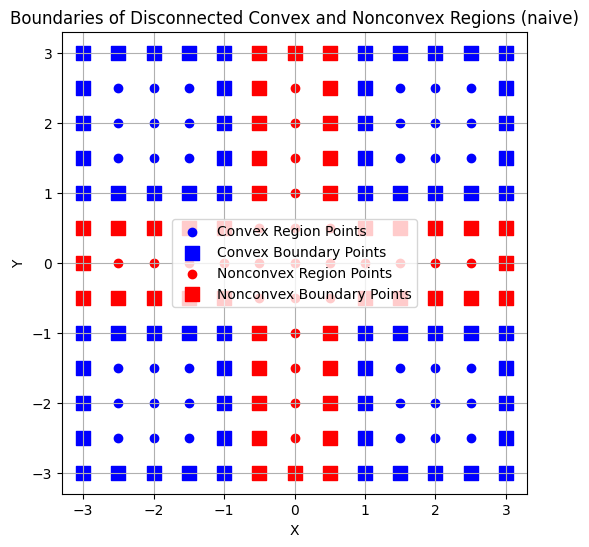

In [28]:
def find_boundary_points(points):
    boundary_points = []
    for point in points:
        is_boundary = False
        px, py = point

        # Check the four adjacent directions
        neighbors = [
            np.array([px - 0.5, py]),  # Left
            np.array([px + 0.5, py]),  # Right
            np.array([px, py - 0.5]),  # Down
            np.array([px, py + 0.5])   # Up
        ]

        # If any neighbor is not in the original set, mark the point as boundary
        for neighbor in neighbors:
            if not any(np.array_equal(neighbor, p) for p in points):
                is_boundary = True
                break

        if is_boundary:
            boundary_points.append(point)

    return boundary_points

times_naive = []
# Find boundary points
for _ in range(100):
    start_time = time.time()
    convex_boundary = find_boundary_points(convex_regions)
    nonconvex_boundary = find_boundary_points(nonconvex_regions)
    end_time = time.time()
    run_time = end_time - start_time
    times_naive.append(run_time)

# Visualization of regions and their boundary points
plt.figure(figsize=(6, 6))

# Plot convex region points
convex_points = np.array(convex_regions)
plt.scatter(convex_points[:, 0], convex_points[:, 1], color='blue', label='Convex Region Points')
# Plot convex boundary points (larger and square marker)
convex_boundary_points = np.array(convex_boundary)
plt.scatter(convex_boundary_points[:, 0], convex_boundary_points[:, 1], color='blue', s=100, marker='s', label='Convex Boundary Points')

# Plot nonconvex region points
nonconvex_points = np.array(nonconvex_regions)
plt.scatter(nonconvex_points[:, 0], nonconvex_points[:, 1], color='red', label='Nonconvex Region Points')
# Plot nonconvex boundary points (larger and square marker)
nonconvex_boundary_points = np.array(nonconvex_boundary)
plt.scatter(nonconvex_boundary_points[:, 0], nonconvex_boundary_points[:, 1], color='red', s=100, marker='s', label='Nonconvex Boundary Points')

# Add legend and labels
plt.legend()
plt.title("Boundaries of Disconnected Convex and Nonconvex Regions (naive)")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


In [14]:
convex_boundary

[array([-3., -3.]),
 array([-2.5, -3. ]),
 array([-2., -3.]),
 array([-1.5, -3. ]),
 array([-1., -3.]),
 array([ 1., -3.]),
 array([ 1.5, -3. ]),
 array([ 2., -3.]),
 array([ 2.5, -3. ]),
 array([ 3., -3.]),
 array([-3. , -2.5]),
 array([-1. , -2.5]),
 array([ 1. , -2.5]),
 array([ 3. , -2.5]),
 array([-3., -2.]),
 array([-1., -2.]),
 array([ 1., -2.]),
 array([ 3., -2.]),
 array([-3. , -1.5]),
 array([-1. , -1.5]),
 array([ 1. , -1.5]),
 array([ 3. , -1.5]),
 array([-3., -1.]),
 array([-2.5, -1. ]),
 array([-2., -1.]),
 array([-1.5, -1. ]),
 array([-1., -1.]),
 array([ 1., -1.]),
 array([ 1.5, -1. ]),
 array([ 2., -1.]),
 array([ 2.5, -1. ]),
 array([ 3., -1.]),
 array([-3.,  1.]),
 array([-2.5,  1. ]),
 array([-2.,  1.]),
 array([-1.5,  1. ]),
 array([-1.,  1.]),
 array([1., 1.]),
 array([1.5, 1. ]),
 array([2., 1.]),
 array([2.5, 1. ]),
 array([3., 1.]),
 array([-3. ,  1.5]),
 array([-1. ,  1.5]),
 array([1. , 1.5]),
 array([3. , 1.5]),
 array([-3.,  2.]),
 array([-1.,  2.]),
 array

In [11]:
# get interval
import numpy as np

# Given boundary points
boundary_points = convex_boundary

# Convert list to numpy array for easier manipulation
boundary_points = np.array(boundary_points)

# Step 1: Group points by their y-coordinate
points_by_y = {}
for point in boundary_points:
    x, y = point
    if y not in points_by_y:
        points_by_y[y] = []
    points_by_y[y].append(x)

# Step 2: For each y-coordinate, sort the x values and find consecutive intervals
intervals = []
for y, x_values in points_by_y.items():
    x_values.sort()
    start = x_values[0]
    for i in range(1, len(x_values)):
        # Check if x values are consecutive (within a threshold, here 0.5)
        if x_values[i] - x_values[i - 1] > 0.5:
            # Save the interval and start a new one
            intervals.append((start, x_values[i - 1], y))
            start = x_values[i]
    # Append the last interval in the current y group
    intervals.append((start, x_values[-1], y))

# Display the resulting intervals
for interval in intervals:
    start_x, end_x, y = interval
    print(f"x = ({start_x}, {end_x}), y = {y}")


x = (-3.0, -1.0), y = -3.0
x = (1.0, 3.0), y = -3.0
x = (-3.0, -3.0), y = -2.5
x = (-1.0, -1.0), y = -2.5
x = (1.0, 1.0), y = -2.5
x = (3.0, 3.0), y = -2.5
x = (-3.0, -3.0), y = -2.0
x = (-1.0, -1.0), y = -2.0
x = (1.0, 1.0), y = -2.0
x = (3.0, 3.0), y = -2.0
x = (-3.0, -3.0), y = -1.5
x = (-1.0, -1.0), y = -1.5
x = (1.0, 1.0), y = -1.5
x = (3.0, 3.0), y = -1.5
x = (-3.0, -1.0), y = -1.0
x = (1.0, 3.0), y = -1.0
x = (-3.0, -1.0), y = 1.0
x = (1.0, 3.0), y = 1.0
x = (-3.0, -3.0), y = 1.5
x = (-1.0, -1.0), y = 1.5
x = (1.0, 1.0), y = 1.5
x = (3.0, 3.0), y = 1.5
x = (-3.0, -3.0), y = 2.0
x = (-1.0, -1.0), y = 2.0
x = (1.0, 1.0), y = 2.0
x = (3.0, 3.0), y = 2.0
x = (-3.0, -3.0), y = 2.5
x = (-1.0, -1.0), y = 2.5
x = (1.0, 1.0), y = 2.5
x = (3.0, 3.0), y = 2.5
x = (-3.0, -1.0), y = 3.0
x = (1.0, 3.0), y = 3.0


In [19]:
# bad!
from collections import defaultdict

def find_rectangles(points):
    # Step 1: Group points by their y-coordinate
    y_dict = defaultdict(list)
    for point in points:
        x, y = point
        y_dict[y].append(x)

    # Step 2: Sort x-coordinates for each y and form x-intervals
    y_intervals = defaultdict(list)
    for y, x_values in y_dict.items():
        x_values.sort()
        start = x_values[0]
        for i in range(1, len(x_values)):
            if x_values[i] != x_values[i - 1] + 0.5:  # Check for consecutive x values
                y_intervals[y].append((start, x_values[i - 1]))
                start = x_values[i]
        y_intervals[y].append((start, x_values[-1]))  # Add the last interval

    # Step 3: Combine y intervals with matching x intervals to form rectangles
    rectangles = []
    sorted_y_keys = sorted(y_intervals.keys())

    i = 0
    while i < len(sorted_y_keys):
        y_start = sorted_y_keys[i]
        for x_interval in y_intervals[y_start]:
            x_start, x_end = x_interval
            y_end = y_start

            # Try to extend the rectangle in the y direction for matching x intervals
            for j in range(i + 1, len(sorted_y_keys)):
                next_y = sorted_y_keys[j]
                if x_interval in y_intervals[next_y]:  # Check if x_interval matches in the next y level
                    y_end = next_y
                else:
                    break
            
            # Only add valid rectangles where both x and y ranges form boundaries
            rectangles.append(((x_start, x_end), (y_start, y_end)))
        
        i += 1

    return rectangles

# Example data
points = [item.tolist() for item in convex_boundary]

# Run the function
rectangles = find_rectangles(points)

# Display the result
for rect in rectangles:
    print(f"x: ({rect[0][0]}, {rect[0][1]}), y: ({rect[1][0]}, {rect[1][1]})")


x: (-3.0, -1.0), y: (-3.0, -3.0)
x: (1.0, 3.0), y: (-3.0, -3.0)
x: (-3.0, -3.0), y: (-2.5, -1.5)
x: (-1.0, -1.0), y: (-2.5, -1.5)
x: (1.0, 1.0), y: (-2.5, -1.5)
x: (3.0, 3.0), y: (-2.5, -1.5)
x: (-3.0, -3.0), y: (-2.0, -1.5)
x: (-1.0, -1.0), y: (-2.0, -1.5)
x: (1.0, 1.0), y: (-2.0, -1.5)
x: (3.0, 3.0), y: (-2.0, -1.5)
x: (-3.0, -3.0), y: (-1.5, -1.5)
x: (-1.0, -1.0), y: (-1.5, -1.5)
x: (1.0, 1.0), y: (-1.5, -1.5)
x: (3.0, 3.0), y: (-1.5, -1.5)
x: (-3.0, -1.0), y: (-1.0, 1.0)
x: (1.0, 3.0), y: (-1.0, 1.0)
x: (-3.0, -1.0), y: (1.0, 1.0)
x: (1.0, 3.0), y: (1.0, 1.0)
x: (-3.0, -3.0), y: (1.5, 2.5)
x: (-1.0, -1.0), y: (1.5, 2.5)
x: (1.0, 1.0), y: (1.5, 2.5)
x: (3.0, 3.0), y: (1.5, 2.5)
x: (-3.0, -3.0), y: (2.0, 2.5)
x: (-1.0, -1.0), y: (2.0, 2.5)
x: (1.0, 1.0), y: (2.0, 2.5)
x: (3.0, 3.0), y: (2.0, 2.5)
x: (-3.0, -3.0), y: (2.5, 2.5)
x: (-1.0, -1.0), y: (2.5, 2.5)
x: (1.0, 1.0), y: (2.5, 2.5)
x: (3.0, 3.0), y: (2.5, 2.5)
x: (-3.0, -1.0), y: (3.0, 3.0)
x: (1.0, 3.0), y: (3.0, 3.0)


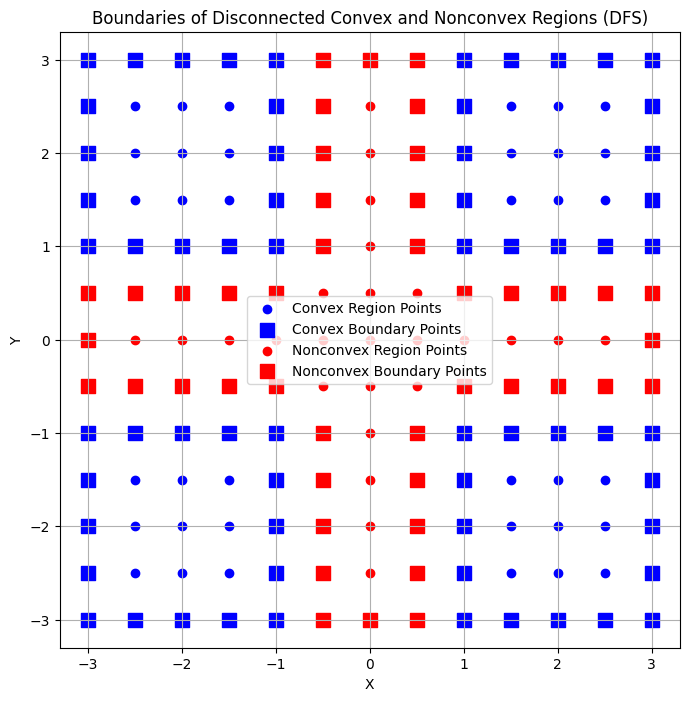

In [22]:
# DFS
import numpy as np
import matplotlib.pyplot as plt

# Convert regions to numpy arrays
points1 = np.array(convex_regions)
points2 = np.array(nonconvex_regions)

# Function to find boundary points for multiple disconnected regions using DFS
def find_all_boundaries_dfs(points):
    points_set = {tuple(p) for p in points}  # Set for fast lookup
    all_boundary_points = []
    visited = set()

    # Define directions (left, right, up, down)
    directions = [(-0.5, 0), (0.5, 0), (0, -0.5), (0, 0.5)]
    
    def is_boundary(point):
        """Check if a point is on the boundary."""
        x, y = point
        for dx, dy in directions:
            neighbor = (x + dx, y + dy)
            if neighbor not in points_set:  # If any neighbor is missing, it's a boundary
                return True
        return False
    
    def dfs(start_point):
        """DFS traversal to find boundary points of a single connected component."""
        stack = [start_point]
        visited.add(start_point)
        boundary_points = set()
        
        while stack:
            current = stack.pop()
            if is_boundary(current):
                boundary_points.add(current)
            
            for dx, dy in directions:
                neighbor = (current[0] + dx, current[1] + dy)
                if neighbor in points_set and neighbor not in visited:
                    visited.add(neighbor)
                    stack.append(neighbor)
        
        return boundary_points

    # Loop through all points to find all disconnected boundaries
    for point in points_set:
        if point not in visited:
            boundary_points = dfs(point)
            all_boundary_points.extend(boundary_points)

    return all_boundary_points

times_dfs = []
for _ in range(100):
    start_time = time.time()
    # Find boundary points for both convex and nonconvex regions using DFS
    convex_boundary_points_dfs = find_all_boundaries_dfs(points1)
    nonconvex_boundary_points_dfs = find_all_boundaries_dfs(points2)
    end_time = time.time()
    run_time = end_time - start_time
    times_dfs.append(run_time)

# Plotting for DFS
plt.figure(figsize=(8, 8))

# Plot convex region points and boundary points
convex_points = np.array(convex_regions)
plt.scatter(convex_points[:, 0], convex_points[:, 1], color='blue', label='Convex Region Points')
if convex_boundary_points_dfs:
    convex_boundary_points_dfs = np.array(list(convex_boundary_points_dfs))
    plt.scatter(convex_boundary_points_dfs[:, 0], convex_boundary_points_dfs[:, 1], color='blue', s=100, marker='s', label='Convex Boundary Points')

# Plot nonconvex region points and boundary points
nonconvex_points = np.array(nonconvex_regions)
plt.scatter(nonconvex_points[:, 0], nonconvex_points[:, 1], color='red', label='Nonconvex Region Points')
if nonconvex_boundary_points_dfs:
    nonconvex_boundary_points_dfs = np.array(list(nonconvex_boundary_points_dfs))
    plt.scatter(nonconvex_boundary_points_dfs[:, 0], nonconvex_boundary_points_dfs[:, 1], color='red', s=100, marker='s', label='Nonconvex Boundary Points')

# Add legend and labels
plt.legend()
plt.title("Boundaries of Disconnected Convex and Nonconvex Regions (DFS)")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


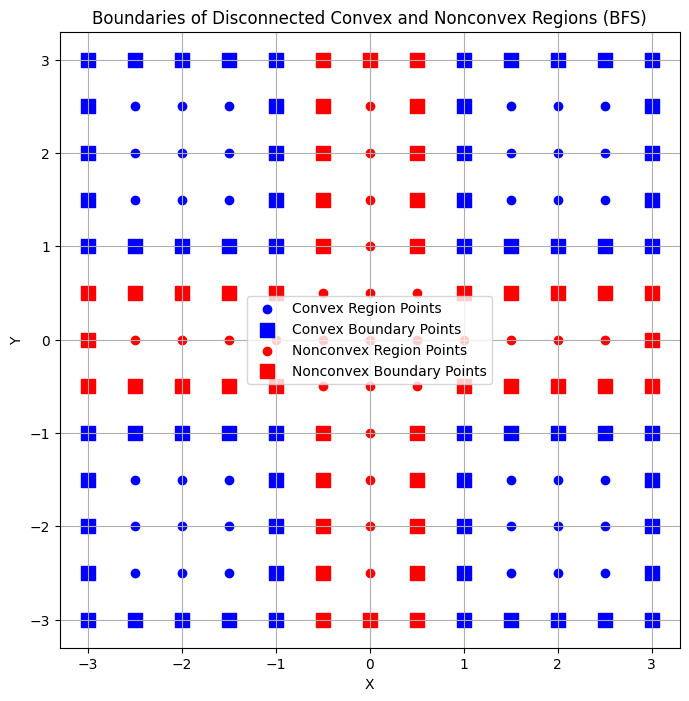

In [23]:
# BFS
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Convert regions to numpy arrays
points1 = np.array(convex_regions)
points2 = np.array(nonconvex_regions)

# Function to find boundary points for multiple disconnected regions using BFS
def find_all_boundaries_bfs(points):
    points_set = {tuple(p) for p in points}  # Set for fast lookup
    all_boundary_points = []
    visited = set()

    # Define directions (left, right, up, down)
    directions = [(-0.5, 0), (0.5, 0), (0, -0.5), (0, 0.5)]
    
    def is_boundary(point):
        """Check if a point is on the boundary."""
        x, y = point
        for dx, dy in directions:
            neighbor = (x + dx, y + dy)
            if neighbor not in points_set:  # If any neighbor is missing, it's a boundary
                return True
        return False
    
    def bfs(start_point):
        """BFS traversal to find boundary points of a single connected component."""
        queue = deque([start_point])
        visited.add(start_point)
        boundary_points = set()
        
        while queue:
            current = queue.popleft()
            if is_boundary(current):
                boundary_points.add(current)
            
            for dx, dy in directions:
                neighbor = (current[0] + dx, current[1] + dy)
                if neighbor in points_set and neighbor not in visited:
                    visited.add(neighbor)
                    queue.append(neighbor)
        
        return boundary_points

    # Loop through all points to find all disconnected boundaries
    for point in points_set:
        if point not in visited:
            boundary_points = bfs(point)
            all_boundary_points.extend(boundary_points)

    return all_boundary_points

times_bfs = []
for _ in range(100):
    start_time = time.time()
    # Find boundary points for both convex and nonconvex regions using BFS
    convex_boundary_points_bfs = find_all_boundaries_bfs(points1)
    nonconvex_boundary_points_bfs = find_all_boundaries_bfs(points2)
    end_time = time.time()
    run_time = end_time - start_time
    times_bfs.append(run_time)

# Plotting for BFS
plt.figure(figsize=(8, 8))

# Plot convex region points and boundary points
convex_points = np.array(convex_regions)
plt.scatter(convex_points[:, 0], convex_points[:, 1], color='blue', label='Convex Region Points')
if convex_boundary_points_bfs:
    convex_boundary_points_bfs = np.array(list(convex_boundary_points_bfs))
    plt.scatter(convex_boundary_points_bfs[:, 0], convex_boundary_points_bfs[:, 1], color='blue', s=100, marker='s', label='Convex Boundary Points')

# Plot nonconvex region points and boundary points
nonconvex_points = np.array(nonconvex_regions)
plt.scatter(nonconvex_points[:, 0], nonconvex_points[:, 1], color='red', label='Nonconvex Region Points')
if nonconvex_boundary_points_bfs:
    nonconvex_boundary_points_bfs = np.array(list(nonconvex_boundary_points_bfs))
    plt.scatter(nonconvex_boundary_points_bfs[:, 0], nonconvex_boundary_points_bfs[:, 1], color='red', s=100, marker='s', label='Nonconvex Boundary Points')

# Add legend and labels
plt.legend()
plt.title("Boundaries of Disconnected Convex and Nonconvex Regions (BFS)")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


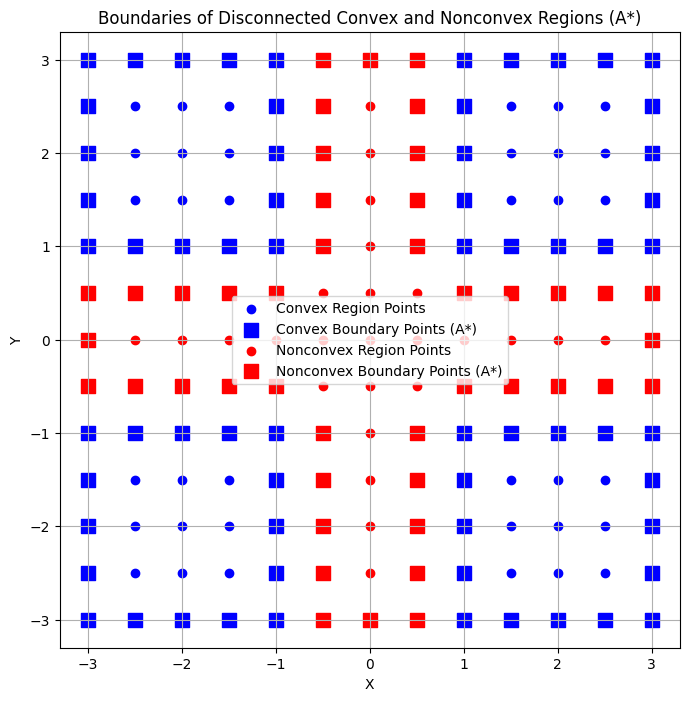

In [24]:
# A star
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappush, heappop

# Convert regions to numpy arrays
points1 = np.array(convex_regions)
points2 = np.array(nonconvex_regions)

# Function to find boundary points for multiple disconnected regions using A*
def find_all_boundaries_astar(points):
    points_set = {tuple(p) for p in points}  # Set for fast lookup
    all_boundary_points = []
    visited = set()

    # Define directions (left, right, up, down)
    directions = [(-0.5, 0), (0.5, 0), (0, -0.5), (0, 0.5)]
    
    def is_boundary(point):
        """Check if a point is on the boundary."""
        x, y = point
        for dx, dy in directions:
            neighbor = (x + dx, y + dy)
            if neighbor not in points_set:  # If any neighbor is missing, it's a boundary
                return True
        return False
    
    def astar(start_point):
        """A* search to find boundary points of a single connected component."""
        boundary_points = set()
        heap = []
        heappush(heap, (0, start_point))
        visited.add(start_point)
        
        while heap:
            _, current = heappop(heap)
            if is_boundary(current):
                boundary_points.add(current)
            
            for dx, dy in directions:
                neighbor = (current[0] + dx, current[1] + dy)
                if neighbor in points_set and neighbor not in visited:
                    visited.add(neighbor)
                    heappush(heap, (0, neighbor))  # For boundary detection, heuristic is simplified to 0
        
        return boundary_points

    # Loop through all points to find all disconnected boundaries
    for point in points_set:
        if point not in visited:
            boundary_points = astar(point)
            all_boundary_points.extend(boundary_points)

    return all_boundary_points

times_astar = []
for _ in range(100):
    start_time = time.time()
    # Find boundary points for both convex and nonconvex regions using A*
    convex_boundary_points_astar = find_all_boundaries_astar(points1)
    nonconvex_boundary_points_astar = find_all_boundaries_astar(points2)
    end_time = time.time()
    run_time = end_time - start_time
    times_astar.append(run_time)

# Plotting for A*
plt.figure(figsize=(8, 8))

# Plot convex region points and boundary points
convex_points = np.array(convex_regions)
plt.scatter(convex_points[:, 0], convex_points[:, 1], color='blue', label='Convex Region Points')
if convex_boundary_points_astar:
    convex_boundary_points_astar = np.array(list(convex_boundary_points_astar))
    plt.scatter(convex_boundary_points_astar[:, 0], convex_boundary_points_astar[:, 1], color='blue', s=100, marker='s', label='Convex Boundary Points (A*)')

# Plot nonconvex region points and boundary points
nonconvex_points = np.array(nonconvex_regions)
plt.scatter(nonconvex_points[:, 0], nonconvex_points[:, 1], color='red', label='Nonconvex Region Points')
if nonconvex_boundary_points_astar:
    nonconvex_boundary_points_astar = np.array(list(nonconvex_boundary_points_astar))
    plt.scatter(nonconvex_boundary_points_astar[:, 0], nonconvex_boundary_points_astar[:, 1], color='red', s=100, marker='s', label='Nonconvex Boundary Points (A*)')

# Add legend and labels
plt.legend()
plt.title("Boundaries of Disconnected Convex and Nonconvex Regions (A*)")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


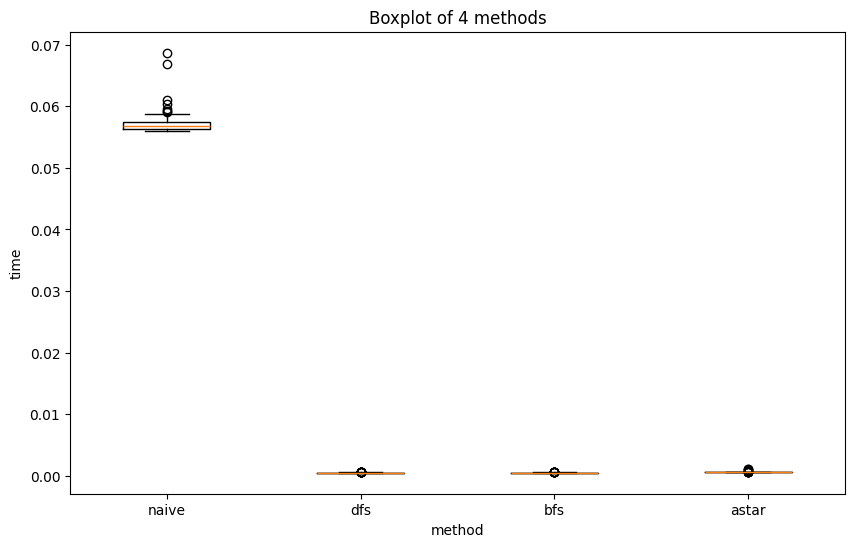

In [29]:
# Generate 5 sample lists of 100 random data points each
data_lists = [times_naive, times_dfs, times_bfs, times_astar]  # Different means for each list

# Create the boxplot with all 5 data sets on the same plot
plt.figure(figsize=(10, 6))
plt.boxplot(data_lists)
plt.title("Boxplot of 4 methods")
plt.xlabel("method")
plt.ylabel("time")
plt.xticks(ticks=range(1, 5), labels=['naive', 'dfs', 'bfs', 'astar'])  # Label each boxplot

plt.show()